# 节点对象

## 基类节点对象
- `inputs` 属性，输入节点组成的 `list`
- `outputs` 属性，输出节点组成的 `list`
- `forward` 方法，正向传播，通过输入节点计算输出
- `backward` 方法，反向传播计算梯度
- `gradients` 属性，保存当前节点对输入节点的梯度，为 `dict` 对象
- `value` 属性，节点操作后的输出值

In [57]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.value = None
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            # 将当前节点添加到，它的所有输入节点的输出节点中
            node.outputs.append(self) # build a connection relationship
            
    def forward(self):
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented

## 接受训练数据及参数的`Input`节点 

In [58]:
class Input(Node):
    """
    用来接受训练数据，其输入节点为空
    """
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name = name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
    
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return "Input Node: {}".format(self.name)

## 仿射节点 
- 输入节点`X,W,B`
- 执行操作`X*W+B`

In [59]:
import numpy as np

In [60]:
X = np.array([1,2,3])
W = np.array([[1,2],[2,4],[3,5]])
B = np.array([1,3])

In [61]:
np.dot(X,W)+B

array([15, 28])

In [62]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
        
    def forward(self):
        self.value = np.dot(self.x_node.value, self.w_node.value)+self.b_node.value
        
    def backward(self):
        for node in self.outputs:
            grad_cost = node.gradients[self]
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost*1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

## 激活节点 

In [63]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
    
    def _sigmoid(self, x):
        return 1./(1+np.exp(-1*x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
        
    def backward(self):
        y = self.value
        self.partial = y*(1-y)
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial

## 损失函数节点 

In [64]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true,y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.diff = y_true_flatten-y_hat_flatten
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2/n)*self.diff
        self.gradients[self.y_hat_node] = (-2/n)*self.diff

# 创建图

## 拓扑排序

In [65]:
def topological_sort(data_with_value):
    """
    输入训练数据，Input对象，创建图；
    """
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    
    # 每个节点的输入节点与输出节点
    # 生成图
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes)>0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in':set(),'out':set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in':set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    # 找出所有只有出度的节点，随机选择一个，并删除该节点所有的输出边；循环至选择出所有节点
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

## 训练模型

In [66]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [67]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

# 示例

In [71]:
from sklearn.datasets import load_boston

data = load_boston()

X_ = data['data']
y_ = data['target']

X_ = (X_-np.mean(X_,axis=0))/np.std(X_,axis=0)

In [72]:
n_features = X_.shape[1]
n_features

13

In [73]:
n_hidden = 10

In [74]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

创建图中节点

In [75]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1') # tensorflow -> Varaible
W2, b2 = Input(name='W2'), Input(name='b2')

In [76]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

$y^1=X_{[13,]}\cdot W^1_{[13,10]}+b^1_{[10,]}$
   
$y^{\sigma} = \sigma(y^1_{[10,]})$
   
$\hat{y}= y^{\sigma}_{[10,]}\cdot W^2_{[10,1]}+b^2_{[1,]}$  

创建图

In [77]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

In [78]:
graph = topological_sort(input_node_with_value)

In [79]:
graph

[Input Node: y,
 Input Node: b1,
 Input Node: b2,
 Input Node: W2,
 Input Node: W1,
 Input Node: X,

训练模型

In [80]:
from sklearn.utils import resample

In [81]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size

for i in range(epochs):
    loss = 0

    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        X.value = X_batch
        y.value = y_batch

        input_node_with_value = {  # -> feed_dict 
            X: X_batch,
            y: y_batch,
            W1: W1.value,
            W2: W2.value,
            b1: b1.value,
            b2: b2.value,
        }

        graph = topological_sort(input_node_with_value)

        training_one_batch(graph)

        learning_rate = 1e-3

        sgd_update(trainable_nodes=[W1, W2, b1, b2],
                   learning_rate=learning_rate)

        loss += graph[-1].value

    if i % 1000 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i + 1, loss / steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 656.861
Epoch: 101, loss = 30.534
Epoch: 201, loss = 22.998
Epoch: 301, loss = 19.092
Epoch: 401, loss = 21.147
Epoch: 501, loss = 16.537
Epoch: 601, loss = 17.207
Epoch: 701, loss = 13.458
Epoch: 801, loss = 12.301
Epoch: 901, loss = 12.968
Epoch: 1001, loss = 11.508
Epoch: 1101, loss = 14.529
Epoch: 1201, loss = 9.997
Epoch: 1301, loss = 10.658
Epoch: 1401, loss = 9.573
Epoch: 1501, loss = 8.555
Epoch: 1601, loss = 8.751
Epoch: 1701, loss = 8.240
Epoch: 1801, loss = 9.727
Epoch: 1901, loss = 6.514
Epoch: 2001, loss = 9.124
Epoch: 2101, loss = 7.923
Epoch: 2201, loss = 7.493
Epoch: 2301, loss = 6.686
Epoch: 2401, loss = 7.282
Epoch: 2501, loss = 7.931
Epoch: 2601, loss = 5.882
Epoch: 2701, loss = 6.295
Epoch: 2801, loss = 7.290
Epoch: 2901, loss = 8.225
Epoch: 3001, loss = 5.995
Epoch: 3101, loss = 6.551
Epoch: 3201, loss = 5.586
Epoch: 3301, loss = 6.341
Epoch: 3401, loss = 8.904
Epoch: 3501, loss = 5.612
Epoch: 3601, loss = 8.401
Epoch: 3701, loss = 7.765
Epoch: 380

查看结果

In [82]:
import matplotlib.pyplot as plt

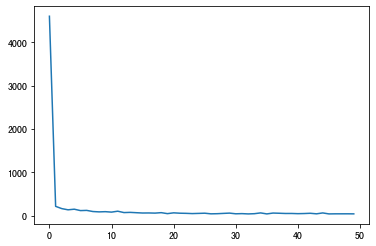

In [83]:
plt.plot(losses)